# Setup

If you haven't already please install mallet. As that will be required to run the following notebook. There is also a back up alterative lda model we will allow usage of (LDA Multicore). 

[Installation of Mallet](http://www.themacroscope.org/?page_id=799)

### Pre Processing

In [13]:
import pandas
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

We have filtered all news headlines from Reuters from 2014 to 2016 by checking for the occurence of the word 'oil'. We then aggregate file corpus into a line corpus, provided as a CSV file ('WTI-NEWS.csv'). We have functions in our Python script that will read this in and perform the following pre-processing steps:

- Remove Stop Words (NLTK) 
- Lower Case (Gensim) 
- Remove Punctuation (Gensim) 
- Remove Numbers (Gensim) 
- Stemmed/Lemmatized (NLTK) 

After this we use the bag of words approach and build up a corpus of pre-processed documents. This is all done by invoking the get_text_data() method.

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [3]:
from CTADaily import get_text_data
text_df, dictionary, corpus = get_text_data('WTI-NEWS.csv', 'Headline')

In [4]:
text_df.head(2)

,Date,Headline
0,2014-01-02,"[brazil, oleo, gas, say, honor, oil, field, debt]"
1,2014-01-02,"[cabot, oil, gas, corpor, declar, dividend]"


### Building The Model

#### Please replace mallet path with your own for this to work 

In [5]:
mallet_path = 'C:\\Users\\Yash\mallet\\bin\\mallet'

In [6]:
from CTADaily import build_lda_model
lda_model = build_lda_model(mallet_path, 'Mallet', corpus, dictionary, num_topics=10)

If you were unable to install Mallet, there is an alternative model type you can use which is the LDA Multicore method from gensim. This can be simply passed into build_lda_model as follows:

In [7]:
#lda_model = build_lda_model('Multicore', corpus, dictionary, num_topics=10)

#### Optimizing Model by Coherence

In [8]:
from gensim.models.coherencemodel import CoherenceModel
from CTADaily import get_tokens 

tokens = get_tokens(text_df, 'Headline')

cm = CoherenceModel(model=lda_model, corpus=corpus, texts=tokens, coherence='c_v')
coherence = cm.get_coherence()
print(coherence)

0.3774953032379646


We see quite a low coherence value of 0.38 for 10 topics. Let's try to optimise this.

In [9]:
from CTADaily import get_coherence_scores
models, scores = get_coherence_scores(mallet_path, tokens, corpus, dictionary, range(1, 60, 10))

Building Model with 1 #Topics
Coherence 0.1532535840128281
Building Model with 11 #Topics
Coherence 0.4019032125590481
Building Model with 21 #Topics
Coherence 0.3662073875370996
Building Model with 31 #Topics
Coherence 0.3705342243334963
Building Model with 41 #Topics
Coherence 0.39140741084946906
Building Model with 51 #Topics
Coherence 0.38472011930903


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

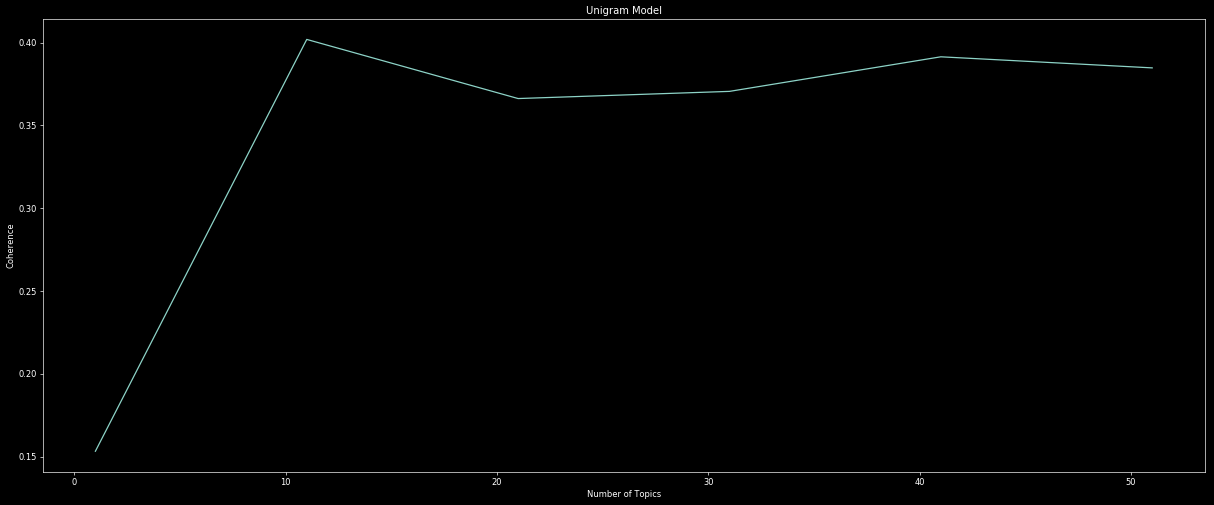

In [11]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 10), dpi= 60)
fig = plt.plot(range(1, 60, 10), scores)
plt.title('Unigram Model')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

#### Analysis

Generally, we see that the coherence is quite low. There may multiple reasons for this. We require more training data, so that the topics could overlap and thus the coherence would become better with a lower number of topics. We may have also considered word n grams to further improve our LDA model coherence.

### Bigram Model

In [18]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser 

words = pandas.read_csv('WTI-NEWS.csv')
bigram_phraser = Phraser(Phrases(tokens, min_count=1, threshold=1))

In [19]:
print(bigram_phraser[tokens[500]])

['north_european', 'oil_royalti', 'trust_announc', 'distribut_first', 'quarter_fiscal']


#### Rebuild Corpus

In [20]:
import gensim.corpora as corpora

bigrams = [bigram_phraser[doc] for doc in tokens]
dictionary = corpora.Dictionary(bigrams)
corpus = [dictionary.doc2bow(text) for text in bigrams]

In [21]:
from CTADaily import get_coherence_scores
models, scores = get_coherence_scores(mallet_path, bigrams, corpus, dictionary, range(1, 61, 10))

Building Model with 1 #Topics
Coherence 0.5424869250498945
Building Model with 11 #Topics
Coherence 0.43087086720449697
Building Model with 21 #Topics
Coherence 0.44942645710578333
Building Model with 31 #Topics
Coherence 0.454572070691892
Building Model with 41 #Topics
Coherence 0.44985736141012617
Building Model with 51 #Topics
Coherence 0.45382691714015844


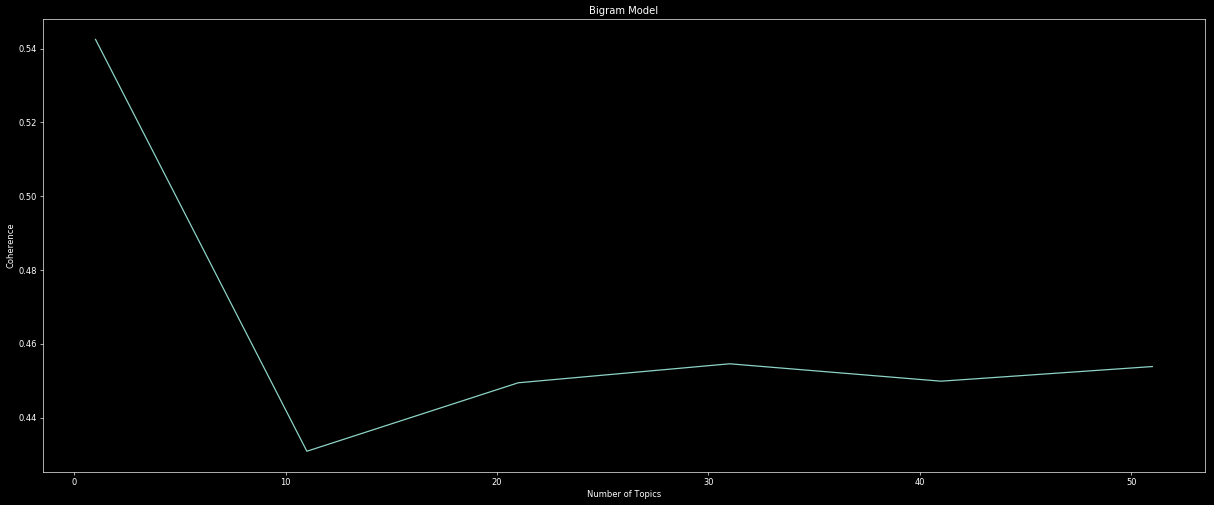

In [22]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 10), dpi= 60)
fig = plt.plot(range(1, 61, 10), scores)
plt.title('Bigram Model')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

In [23]:
from CTADaily import get_coherence_scores
models, scores = get_coherence_scores(mallet_path, bigrams, corpus, dictionary, range(4, 11, 1))

Building Model with 4 #Topics
Coherence 0.442873749690941
Building Model with 5 #Topics
Coherence 0.45949169920525634
Building Model with 6 #Topics
Coherence 0.45385792334910313
Building Model with 7 #Topics
Coherence 0.42815835991390483
Building Model with 8 #Topics
Coherence 0.4456775318449415
Building Model with 9 #Topics
Coherence 0.4091481288706537
Building Model with 10 #Topics
Coherence 0.43400787662219387


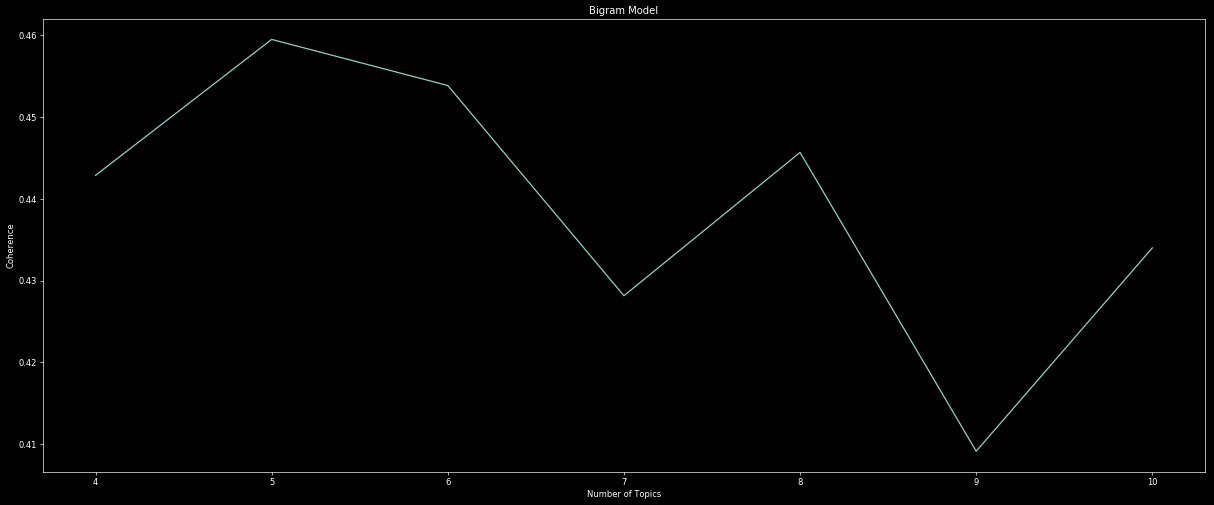

In [24]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 10), dpi= 60)
fig = plt.plot(range(4, 11, 1), scores)
plt.title('Bigram Model')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

In [25]:
max_idx = scores.index(max(scores))
num_topics = 4 + max_idx
lda_model = models[max_idx]
scores[max_idx]

0.45949169920525634

### Visualising Topics

In [26]:
import pyLDAvis
import pyLDAvis.gensim
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
pyLDAvis.enable_notebook()
model = malletmodel2ldamodel(lda_model)
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

C:\Users\Yash\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.000597  0.000158       1        1  20.118850
0      0.000205 -0.000602       2        1  20.118642
2     -0.000601  0.000842       3        1  20.019104
1     -0.000722 -0.000598       4        1  19.887852
3      0.000522  0.000199       5        1  19.855553, topic_info=      Category      Freq                 Term     Total  loglift  logprob
term                                                                     
21232  Default  5.000000         offshor_fuel  5.000000  30.0000  30.0000
11741  Default  6.000000               cloudi  6.000000  29.0000  29.0000
20037  Default  6.000000     updat_petrochina  6.000000  28.0000  28.0000
7767   Default  6.000000                 anti  6.000000  27.0000  27.0000
9768   Default  6.000000         oil_fraction  6.000000  26.0000  26.0000
8864   Default  6.000000            rpt_islam  6.000000  25.0000  25.0000
20739  Default  6.000000           vote_begin  6.000000  24.0000  24.0000
8404   Default  5.000000             bradesco  5.000000  23.0000  23.0000
14955  Default  6.000000      contango_narrow  6.000000  22.0000  22.0000
20496  Default  6.000000       brief_advantag  6.000000  21.0000  21.0000
19701  Default  6.000000             set_date  6.000000  20.0000  20.0000
17313  Default  6.000000           kill_south  6.000000  19.0000  19.0000
1803   Default  6.000000   investor_symposium  6.000000  18.0000  18.0000
12557  Default  5.000000          look_beyond  5.000000  17.0000  17.0000
5517   Default  6.000000            gas_engag  6.000000  16.0000  16.0000
21201  Default  5.000000          brexit_drag  5.000000  15.0000  15.0000
17013  Default  5.000000        compound_kill  5.000000  14.0000  14.0000
8452   Default  6.000000           timelin_bp  6.000000  13.0000  13.0000
14030  Default  5.000000             ordinari  5.000000  12.0000  12.0000
17439  Default  5.000000          work_report  5.000000  11.0000  11.0000
20287  Default  6.000000                 ruin  6.000000  10.0000  10.0000
17888  Default  6.000000                 fenc  6.000000   9.0000   9.0000
7287   Default  6.000000  halliburton_chevron  6.000000   8.0000   8.0000
14896  Default  5.000000                 snip  5.000000   7.0000   7.0000
11279  Default  5.000000           kerri_feel  5.000000   6.0000   6.0000
19554  Default  5.000000     contract_present  5.000000   5.0000   5.0000
2677   Default  5.000000                fluor  5.000000   4.0000   4.0000
5092   Default  6.000000             lake_oil  6.000000   3.0000   3.0000
20049  Default  6.000000          driller_cut  6.000000   2.0000   2.0000
2862   Default  6.000000     unexplod_ordnanc  6.000000   1.0000   1.0000
...        ...       ...                  ...       ...      ...      ...
19362   Topic5  1.361020            warn_earn  5.477028   0.2244  -9.8408
18745   Topic5  1.544686              expedit  6.221121   0.2236  -9.7142
18865   Topic5  1.386070          oil_proffer  5.589545   0.2223  -9.8226
18275   Topic5  1.454964        donlink_grain  5.867727   0.2222  -9.7741
16310   Topic5  1.474103     brazilian_govern  5.952085   0.2210  -9.7610
20907   Topic5  1.552448             russneft  6.277885   0.2195  -9.7092
7660    Topic5  1.471749             arclight  5.954191   0.2190  -9.7626
4244    Topic5  1.480964       result_guidanc  5.994059   0.2186  -9.7564
16721   Topic5  1.503728          shelter_gas  6.090104   0.2180  -9.7411
17935   Topic5  1.504505           capex_save  6.098666   0.2171  -9.7406
6854    Topic5  1.542585           offici_say  6.272780   0.2139  -9.7156
137     Topic5  1.497491          oil_pipelin  6.074020   0.2165  -9.7453
20672   Topic5  1.632514                rehab  6.717728   0.2021  -9.6589
17209   Topic5  1.537701          subcommitte  6.269862   0.2112  -9.7188
19813   Topic5  1.569409          slip_record  6.428186   0.2067  -9.6984
12666   Topic5  1.605923   

### Regression Model

We will now be able to get the topic distribution for each document. We want to use these probabilities as features for our regression, combined with the date the headline was published by Reuters. We will need to unpack the tuples, to remove the topic number and only give us the probability. We will do this for all columns before merging date

In [27]:
import pandas
topic_dist_df = pandas.DataFrame(lda_model[corpus])

for column in topic_dist_df.columns:
    topic_dist_df[column] = topic_dist_df[column].apply(lambda x : x[1])

In [28]:
topic_dist_df.head(2)

,0,1,2,3,4
0,0.240404,0.200000,0.195960,0.181818,0.181818
1,0.199161,0.188679,0.226415,0.188679,0.197065


In [29]:
dates = pandas.read_csv('WTI-NEWS.csv')['Date']
topic_dist_df = pandas.concat([dates, topic_dist_df], axis=1, sort=False)

In [30]:
topic_dist_df.head(2)

,Date,0,1,2,3,4
0,2014-01-02,0.240404,0.200000,0.195960,0.181818,0.181818
1,2014-01-02,0.199161,0.188679,0.226415,0.188679,0.197065


Now we will merge the WTI Crude Oil Prices from our exported historical data. We have more dates in that dataset than the range of the dates from our headlines. Hence, we will perform an inner join between them on the matching column 'Date'. However, instead of using the raw price we will use a dummy variable to convert the price from a continous variable to a binary variable. 

#### Dummy Variable

It would be a lot more challenging to be able to use a text data set to predict a variable such as price, due to it's volatile nature especially for a commodity. This would require a much more sophisticated setup than the one provided here. Whilst not impossible, I would require something used in class such as Iterative Topic Modelling with Time Series Feedback to really create strong topic vectors such that we could then use the topic distribution and the word distribution within that to perform time series prediction. However, for this project the main aim will be to look at a document. Calculate it's topic distribution and tell the user whether it is a up or down day for that commodity, much like sentiment analysis. 

In [31]:
wti_prices = pandas.read_csv('DCOILWTICO.csv')

Let's shift our price vector ahead one day and see if that price is higher

In [32]:
wti_prices['Movement'] = (wti_prices['DCOILWTICO'] > wti_prices['DCOILWTICO'].shift(+1)).astype(int)

In [33]:
wti_prices['DCOILWTICO'].head(5)

0    98.32
1    97.25
2    97.21
3    96.27
4    97.18
Name: DCOILWTICO, dtype: object

In [34]:
wti_prices['Movement'].head(5)

0    0
1    0
2    0
3    0
4    1
Name: Movement, dtype: int32

We will now merge on date and only include price movement. 

In [35]:
topic_prices = pandas.merge(topic_dist_df, wti_prices[['Date', 'Movement']], on='Date')

In [36]:
topic_prices.head(2)

,Date,0,1,2,3,4,Movement
0,2014-01-02,0.240404,0.200000,0.195960,0.181818,0.181818,1
1,2014-01-02,0.199161,0.188679,0.226415,0.188679,0.197065,1


In [37]:
columns = ['Date'] + ['Topic {}'.format(i) for i in range(num_topics)] + ['Movement']
topic_prices.columns = columns

Let's save this to a file for easier analysis.

In [38]:
topic_prices.to_csv('WTI-LDA-TOPIC.csv', index=False)

#### Autocorrelation

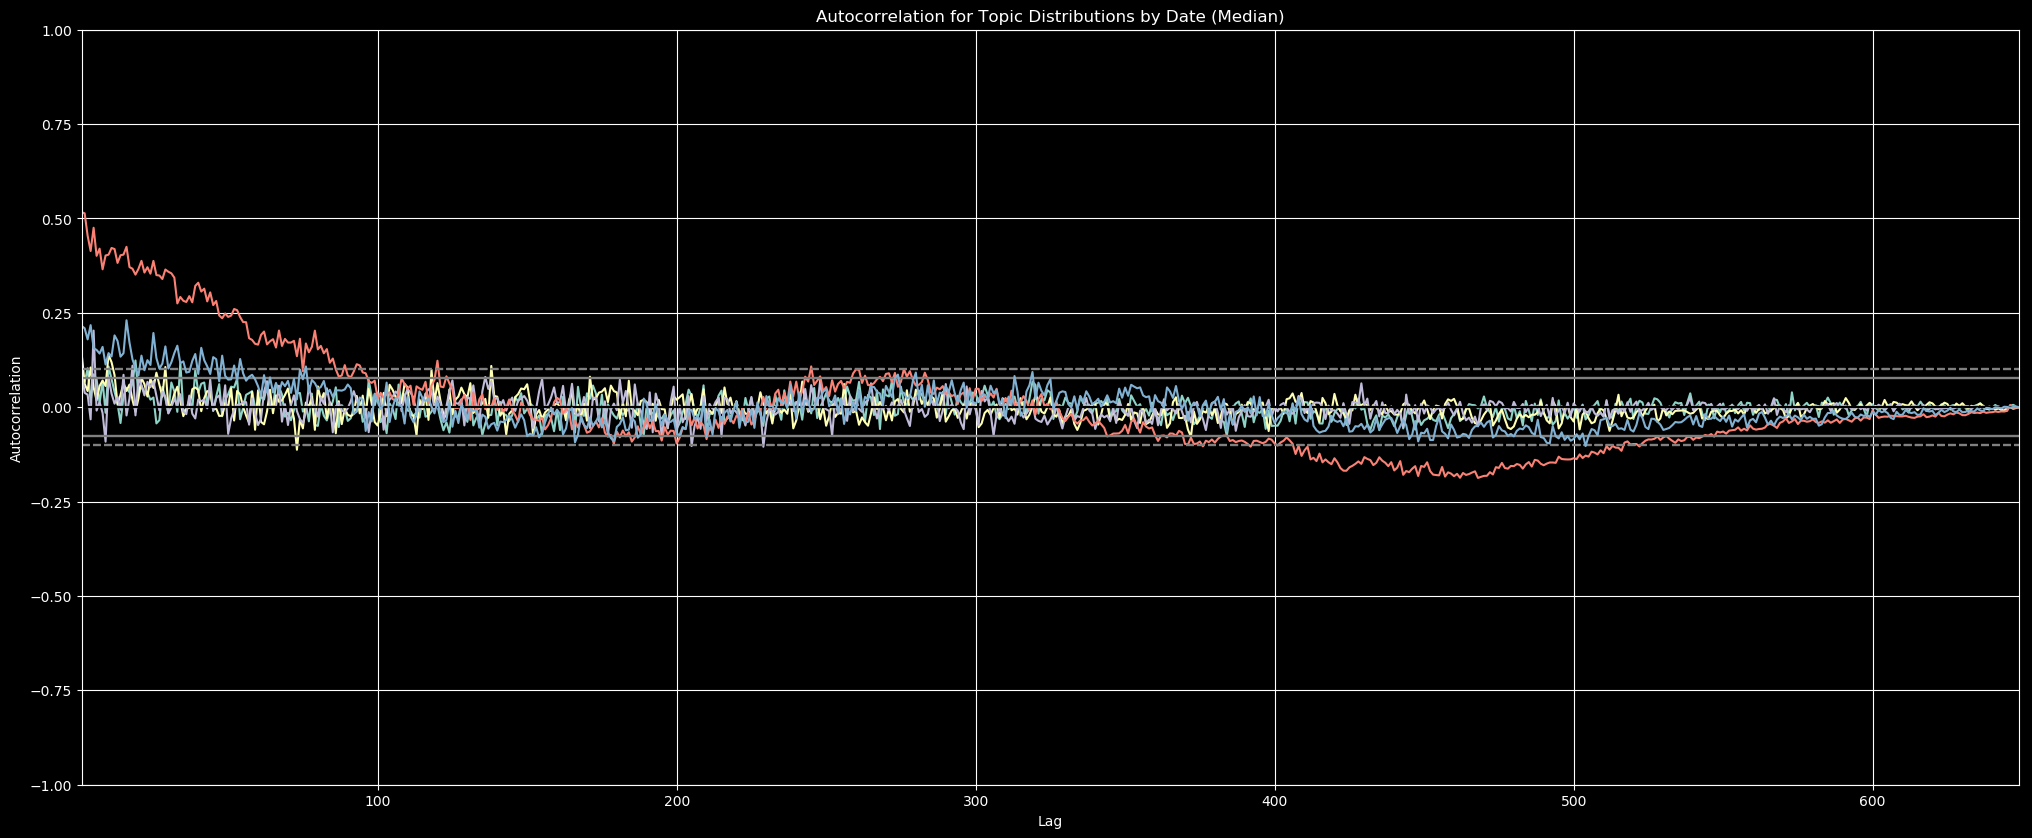

In [39]:
from pandas.plotting import autocorrelation_plot

topic_list = ['Topic {}'.format(i) for i in range(num_topics)]

fig = plt.figure(figsize=(25, 10), dpi=100)
for topic in topic_list:
    autocorrelation_plot(topic_prices[['Date', topic]].groupby('Date').median()[topic])
plt.title('Autocorrelation for Topic Distributions by Date (Median)')
plt.show()

This shows that there is significant autocorrelation within the topic itself over time, which makes intuitive sense. This last a long period of time, we can see only after about 50 periods does this autocorrelation become acceptable.

In [40]:
topic_medians = pandas.DataFrame()
for topic in topic_list:
    topic_medians[topic] = topic_prices[['Date', topic]].groupby('Date').median()[topic]

#### Train and Test Split

We can't randomly sample training and testing data, as this is a time series dataset. We would not provide a robust model by looking ahead. Therefore, we would want to allow for chronological order whilst splitting the data into a training and test set. 

In [41]:
topic_medians['Date'] = topic_medians.index
data_set = pandas.merge(topic_medians, wti_prices, on='Date')
X = data_set[topic_list]
y = data_set['Movement']

C:\Users\Yash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
num_obs = len(data_set)
split = int(0.8*num_obs)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [46]:
import statsmodels.formula.api as sm
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Movement   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     89.28
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           1.68e-67
Time:                        23:50:45   Log-Likelihood:                -370.80
No. Observations:                 519   AIC:                             751.6
Df Residuals:                     514   BIC:                             772.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Topic 0        3.6475      2.410      1.514      0.131      -1.087       8.382
Topic 1       -3.8719      2.396     -1.616      0.107      -8.578       0.835
Topic 2        5.4912      2.483      2.212      0.027       0.613      10.369
Topic 3       -1.0991      1.613     -0.681      0.496      -4.269       2.070
Topic 4       -1.9421      2.117     -0.917      0.359      -6.102       2.218
==============================================================================
Omnibus:                        2.264   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.322   Jarque-Bera (JB):               80.819
Skew:                           0.161   Prob(JB):                     2.82e-18
Kurtosis:                       1.094   Cond. No.                         57.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
X_new = topic_prices[topic_list]
y_new = topic_prices['Movement']

num_obs = len(X_new)
split = int(0.9*num_obs)

In [48]:
print('Using all documents now, with observation count : {}'.format(num_obs))

Using all documents now, with observation count : 17715


In [49]:
X_new_train, X_new_test = X_new[:split], X_new[split:]
y_new_train, y_new_test = y_new[:split], y_new[split:]

from sklearn import svm
clf = svm.SVC()
clf.fit(X_new_train.values, y_new_train.values)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [50]:
svm_accuracy = clf.score(X_new_test.values, y_new_test.values)
print('SVM Accuracy {:.2f}%'.format(svm_accuracy*100))

SVM Accuracy 43.62%


In [51]:
clf = svm.SVC()
clf.fit(X_train.values, y_train.values)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
svm_accuracy = clf.score(X_test.values, y_test.values)
print('SVM Accuracy {:.2f}%'.format(svm_accuracy*100))

SVM Accuracy 46.92%
